In [ ]:
#Checking the allocated GPU on Colab
!nvidia-smi

Tue Nov 10 08:09:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Import google drive stuffs to save data and/or read data
#Mount to our Drive
from google.colab import drive
drive.mount('/content/drive')

#Define the root folder of our project.
#Replace /CE4042/from_scratch with the root folder address for this project
#on your Google Drive
drive_prefix = '/content/drive/My Drive/CE4042/from_scratch'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Other import statements
!pip install pickle5

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import pickle5
import math
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#Helper method to load all train, test and val pickle file
def load_file(filename):
    with open(filename + '.pkl', 'rb') as serialized_file:
        return pickle5.load(serialized_file)

In [ ]:
#Define some constants
IMAGE_SIZE = 227 #for feeding into our pipeline
NUM_CHANNELS = 3
BATCH_SIZE = 50
WIDTH = 256
HEIGHT = 256
CROPPED_WIDTH = 227
CROPPED_HEIGHT = 227
NUM_CLASSES = 1 #Binary
#random SEED
SEED = 10
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Learning rate constant
LR_INIT = 1e-3

#Training for epoch
EPOCHS = 500

#Specifying the fold number (0-4) of the cross-validation process
#Specifying the bag number (0-2) that we are running this fold for
fold = 0
bag = 2

#Name of the experiment type. This must be a folder created under your
#root project folder specified by drive_prefix above
experiment_prefix = '/baseline_model'
save_model = True 

In [ ]:
#Calculate schedule drop based on epoch supplied (paper said drop to 1e-4 when 10k epochs which is equivalent to drop 1e-3 by 10% which is 1e-4)
def step_decay(epoch):
    init_lrate = 1e-3 #TOCHANGE
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#Definition of weight initializers, optimizers, loss function and learning rate
weight_init = keras.initializers.TruncatedNormal(mean=0.0,stddev=0.01,seed=SEED)
#bias_init = tf.keras.initializers.Constant(value=0.1)
sgd = keras.optimizers.SGD(learning_rate=LR_INIT,momentum=0.0) #TOCHANGE
loss_func = keras.losses.BinaryCrossentropy()
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
#Mount our google drive to get data and/or save data to there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the serialized data from our drive.
#Refer to gender_preprocessing.ipynb for details on how these are generated
train_file = load_file(drive_prefix + '/serialized/gender/cv_fold_%s_train_subset'%fold)
val_file = load_file(drive_prefix + '/serialized/gender/cv_fold_%s_val'%fold)

#Load images and label from the deserialized object
train_images = np.array(train_file['images'])
train_genders = np.array(train_file['genders'])

val_images = np.array(val_file['images'])
val_genders = np.array(val_file['genders'])

print ("Train+Val Details for fold: %s" % fold)
print (train_images.shape)
print (train_genders.shape)

print (val_images.shape)
print (val_genders.shape)
print(' ')

X_train = train_images
y_train = train_genders

X_val = val_images
y_val = val_genders

Train+Val Details for fold: 0
(10843, 256, 256, 3)
(10843,)
(3205, 256, 256, 3)
(3205,)
 


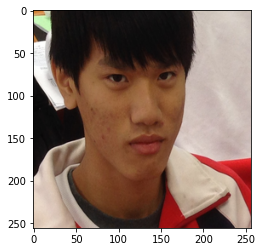

In [ ]:
#Quick check of a random image to see if the size is 256x256 as requested by the paper
import matplotlib.pyplot as plt
img = X_train[100,:,:,:]
plt.imshow(img)

In [ ]:
#Centre Cropping image before feeding into training
#Size should be 227x227 now
left = int((WIDTH-CROPPED_WIDTH)/2)
top = int((HEIGHT-CROPPED_HEIGHT)/2)
right = int((WIDTH+CROPPED_WIDTH)/2)
bottom = int((HEIGHT+CROPPED_HEIGHT)/2)

X_train = X_train[:,left:right,top:bottom,:]
X_val = X_val[:,left:right,top:bottom,:]
print(X_train.shape)
print(X_val.shape)

(10843, 227, 227, 3)
(3205, 227, 227, 3)


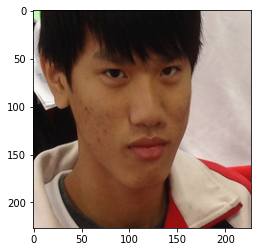

In [ ]:
#Check if cropped to 227x227 or not?
img = X_train[100,:,:,:]
plt.imshow(img)

In [ ]:
#Define model builder
def get_baseline_model():
    model = keras.models.Sequential()
    #First convolution layer with 96 filters, 7x7 kernel, stride = 4, valid padding
    #Followed by max pooling with 3x3 kernel, stride = 2, channel last by default
    #Reason for padding here is because using odd window for max pool layer while the stride 
    #is even.
    # Output desired blob is 96x28x28
    model.add(keras.layers.Conv2D(96, (7,7),input_shape=(CROPPED_WIDTH,CROPPED_HEIGHT,NUM_CHANNELS),strides=4,padding='valid',activation='relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2,padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    #Second Conv layer with 256 filters, 5x5 kernel and relu, padding = same
    #Next is maxpool 3x3, stride =2
    #Output should be 14x14
    model.add(keras.layers.Conv2D(256, (5,5), padding='same',activation = 'relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    #Last conv layer with 384 filters, 3x3 kernel, relu activation, same padding
    #Output after Max pool should be 7x7
    model.add(keras.layers.Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    #Flatten
    model.add(keras.layers.Flatten())
    #FC1:
    model.add(keras.layers.Dense(512,activation="relu",kernel_initializer=weight_init))
    #Dropout
    model.add(keras.layers.Dropout(0.5))
    #FC2:
    model.add(keras.layers.Dense(512,activation='relu',kernel_initializer=weight_init))
    #Dropout
    model.add(keras.layers.Dropout(0.5))
    #FC3
    model.add(keras.layers.Dense(NUM_CLASSES,activation ='sigmoid',kernel_initializer=weight_init))
    
    #Compile the model
    model.compile(loss=loss_func,optimizer=sgd,metrics=['accuracy'])

    return model

In [ ]:
#Define Augmentation (by random flipping)
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

#Fit that to the training set
train_datagen.fit(X_train)

In [ ]:
#Checkpoint callbacks, save max accuracy weights.
#During training, the history of the model and best validation accuracy is saved
#to a .csv and .h5 files respectively.
#These are stored in drive_prefix + experiment_prefix folder.
#Make the changes above accordingly to your choice.
checkpoint = keras.callbacks.ModelCheckpoint(drive_prefix + experiment_prefix + '/baseline_cv_fold_%s_bag_%s.h5'%(fold,bag), monitor='val_accuracy', verbose=1, mode='max',save_best_only = True)
csv_logger = keras.callbacks.CSVLogger(drive_prefix + experiment_prefix + '/baseline_cv_fold_%s_bag_%s.csv'%(fold,bag))
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=30)
if save_model:
  callbacks = [lrate,checkpoint,csv_logger,early_stopping]
else:
  callbacks = [lrate,csv_logger,early_stopping]

#Train the model
model = get_baseline_model()
model.summary()
results = model.fit(train_datagen.flow(X_train,y_train,batch_size=BATCH_SIZE,seed=SEED),
                              epochs=EPOCHS,
                              verbose=2,
                              callbacks=callbacks,
                              validation_data = (X_val,y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)       8